# Remote Sensing Time Series for Vegetation Management Units

In [1]:
# Import libraries
import matplotlib.pyplot as plt
from datetime import date

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from sentinelhub import SHConfig, FisRequest, BBox, Geometry, CRS, WcsRequest, CustomUrlParam, \
    DataCollection, HistogramType
from sentinelhub.time_utils import iso_to_datetime, parse_time

# Setting consistent plotting style throughout notebook
sns.set_style("white")
sns.set(font_scale=1)

# Set pandas df display options
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
# SentinelHub configuration
config = SHConfig()
config.instance_id = 'e0d91a9e-9e07-4ba3-a274-4a261d555721' # Instance ID for the Configuration
config.sh_client_id = '6b0f1254-59e8-4349-bcd3-6a56e3ea651e' # Credentials from the OAuth client
config.sh_client_secret = 'spD*%T/nPjY&/]45iXyYqEjvk_ulGn?PEHb/;};T'
config.save()

### Functions

In [3]:
def fis_data_to_dataframe(fis_data):
    """ Creates a DataFrame from list of FIS responses
    
    Parameters
    -----------
    fis_data : list
        list of data responses from FIS request

    Returns
    -----------
    output : pandas dataframe
        DF containing formatted results
    
    """
    # Setup columns in df
    columns = ['date', 'min', 'max', 'mean', 'stDev'] # Columns for band ratio result
    clm_columns = ['clm_mean'] # Columns for Cloud Mask
    snw_columns = ['snw_mean'] # Columns for snow detection
    
    # Lists to store results
    data = []
    clm_data = []
    snw_data = []
    
    
    # Loops over multipolygons?
    for fis_response in fis_data:
            
            i = 0
            # Loop over channels
            for channel, channel_stats in fis_response.items():
                
                # Results channel
                if channel == 'C0':
                    for stat in channel_stats:
                        row = [parse_time(stat['date'])]
                        for column in columns[1:]:
                            row.append(stat['basicStats'][column])
                        data.append(row)
                
                # CLM channel
                elif channel == 'C1':
                    for stat in channel_stats:
                        row = [stat['basicStats']['mean']]
                        clm_data.append(row)
                
                # SNW channel
                else: 
                    for stat in channel_stats:
                        row = [stat['basicStats']['mean']]
                        snw_data.append(row)                    
            
            # Convert the lists to df
            data_df = pd.DataFrame(data, columns=columns)
            clm_data_df = pd.DataFrame(clm_data, columns=clm_columns)
            snw_data_df = pd.DataFrame(snw_data, columns=snw_columns)
            
            # Concatenate the df 
            output_df = pd.concat([data_df, clm_data_df, snw_data_df], axis = 1)
            
    return output_df

### Import polygons

#### Import VMU's

In [7]:
# Open vector file
#vmu_path = r"E:\McKinley\vectors\VMU_OSM_boundaries_NAD83_shifted_dissolved.shp" ## Single merged vector for all polys
vmu_path = r"E:\McKinley\vectors\VMU_OSM_boundaries_NAD83_shifted.shp"
vmu_polys = gpd.read_file(vmu_path)

# Reproject polys to WGS84
#vmu_polys = vmu_polys.to_crs("EPSG:4326")

# Explode multipolygons to polygons to query with FIS request
vmu_polys_exploded = vmu_polys.explode()

In [8]:
vmu_polys

,OBJECTID,Layer,VMU,Acres,Area_Name,Explan,alt_VMU,Shape_Leng,Shape_Area,geometry
0,1.0,VEGETATION UNITS,1,933.595543,VMU #1,OSM VMU 1 (~ 934 acres),1,41116.083109,4.066747e+07,"POLYGON ((2394568.576 1716911.822, 2394765.901..."
1,2.0,VEGETATION UNITS,8,1044.589721,VMU #8,"OSM VMU 8 (~ 1,045 acres)",8,48098.879002,4.550234e+07,"MULTIPOLYGON (((2368979.712 1686609.589, 23690..."
2,3.0,VEGETATION UNITS,2,1085.050429,VMU #2,"OSM VMU 2 (~ 1,085 acres)",2,35077.142826,4.726484e+07,"POLYGON ((2388417.613 1703883.727, 2388323.284..."
3,4.0,VEGETATION UNITS,3,970.122458,VMU #3,OSM VMU 3 (~ 970 acres),3,48749.181441,4.267023e+07,"POLYGON ((2375817.697 1698474.138, 2375798.969..."
4,5.0,VEGETATION UNITS,5,1129.115603,VMU #5,"OSM VMU 5 (~ 1,129 acres)",5,38980.289338,4.923755e+07,"POLYGON ((2380940.256 1702131.784, 2380930.057..."
5,6.0,VEGETATION UNITS,7,1044.674727,VMU #7,"OSM VMU 7 (~ 1,045 acres)",7,32711.237920,4.550608e+07,"POLYGON ((2401897.590 1705705.204, 2401907.951..."
6,7.0,VEGETATION UNITS,6,1024.486821,VMU #6,"OSM VMU 6 (~ 1,024 acres)",6,36305.044128,4.462669e+07,"POLYGON ((2397473.451 1698067.134, 2397466.576..."
7,8.0,VEGETATION UNITS,4,1242.136241,VMU #4,"OSM VMU 4 (~ 1,242 acres)",4,48188.559152,5.410752e+07,"POLYGON ((2402588.673 1714669.096, 2402609.986..."
8,9.0,VEGETATION UNITS,999,180.925617,North Facilities Area,North Facilities Area (~180 acres),NFA,13664.905870,7.881126e+06,"POLYGON ((2380744.928 1700656.385, 2380745.269..."


### Loop through the VMU's and perform FIS query

In [5]:
# Create empty list to store results for all VMU's
output_list = []

# For testing only
# i = 0

# Loop over VMU's
for index, row in vmu_polys_exploded.iterrows():

    # For testing only
#     i = i + 1
#     if i > 1:
#         continue

    # Process specific VMU's
    if (row.VMU == 1 or row.VMU == 3):

        # Status message
        print('Now processing VMU: ' + str(row.VMU))

        # Setup parameters for FIS request
        geometry_list = Geometry(row.geometry, CRS.WGS84)
        time_interval = ('2017-01-01', date.today())
        ndvi_script = 'return [[(B08 - B04) / (B08 + B04)], CLM, SNW]'

        fis_request = FisRequest(
            data_collection=DataCollection.SENTINEL2_L2A,
            layer='BANDS-S2-L2A',
            geometry_list=[geometry_list],
            time=time_interval,
            resolution='100m',
            custom_url_params={CustomUrlParam.EVALSCRIPT: ndvi_script},
            config=config
        )

        # Run the FIS request
        fis_data = fis_request.get_data()

        # Convert the FIS result to a dataframe
        fis_df = fis_data_to_dataframe(fis_data)

        # Add the VMU to the dataframe
        fis_df['VMU'] = row.VMU

        # Append the df to the temporary list
        output_list.append(fis_df)

    else:
        # Status message
        print('skipping this VMU')
    
    # Cloud mask using CLM: https://forum.sentinel-hub.com/t/clarification-regard-the-cloud-mask-for-fis/3204/2

# Concatenate the VMU results into a single DF
fis_df_all_raw = pd.concat(output_list, axis=0)
# fis_df_all_raw

Now processing VMU: 1
skipping this VMU
skipping this VMU
skipping this VMU
Now processing VMU: 3
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU
skipping this VMU


In [17]:
fis_df_all_raw

,date,min,max,mean,stDev,clm_mean,snw_mean,VMU
0,2021-04-24,0.089496,0.319263,0.144142,0.038155,0.000000,0.000000,1
1,2021-04-21,0.051765,0.165723,0.083623,0.017165,1.000000,0.000000,1
2,2021-04-19,0.095052,0.358066,0.148924,0.041739,0.000000,0.000000,1
3,2021-04-16,0.079338,0.312217,0.132363,0.038365,0.000000,0.000000,1
4,2021-04-14,0.093023,0.331255,0.142107,0.040482,0.000000,0.000000,1
5,2021-04-11,0.078568,0.326793,0.127373,0.041018,0.000000,0.000000,1
6,2021-04-09,0.094557,0.372114,0.141255,0.043872,0.000000,0.000000,1
7,2021-04-06,0.083247,0.345013,0.127215,0.044118,0.000000,0.000000,1
8,2021-04-04,-0.503089,0.413091,0.086247,0.084749,0.412556,0.000000,1
9,2021-04-01,0.082941,0.277487,0.112527,0.030678,0.000000,0.000000,1


### Clean up the FIS results df

In [23]:
fis_df_all = fis_df_all_raw.copy(deep=True)

# Convert stats values from objects to float
fis_df_all['min'] = fis_df_all['min'].astype(float, errors = 'raise')
fis_df_all['max'] = fis_df_all['max'].astype(float, errors = 'raise')
fis_df_all['mean'] = fis_df_all['mean'].astype(float, errors = 'raise')
fis_df_all['stDev'] = fis_df_all['stDev'].astype(float, errors = 'raise')
fis_df_all['clm_mean'] = fis_df_all['clm_mean'].astype(float, errors = 'raise')
fis_df_all['snw_mean'] = fis_df_all['snw_mean'].astype(float, errors = 'raise')

# Drop rows with NaN
fis_df_all.dropna(inplace=True)

# Remove cloudy results
fis_df_all.drop(fis_df_all[fis_df_all['clm_mean'] > 0].index, inplace = True)

# Format the date field
fis_df_all['date'] = pd.to_datetime(fis_df_all['date'])

# Average over multipolygon VMU's
fis_df_all = fis_df_all.groupby(['date', 'VMU']).mean()

# Sort by date
fis_df_all.sort_values(['VMU','date'], inplace=True)

# Reset index
fis_df_all.reset_index(inplace=True)
fis_df_all.set_index('date', inplace=True)

fis_df_all

,VMU,min,max,mean,stDev,clm_mean,snw_mean
date,,,,,,,
2017-02-01,1,-0.065101,0.418167,-0.000307,0.079268,0.0,83.347534
2017-02-04,1,-0.085023,0.604396,0.025904,0.107958,0.0,48.587444
2017-02-21,1,0.088458,0.613929,0.156266,0.091894,0.0,0.000000
2017-03-06,1,-0.043166,0.368078,0.108077,0.074034,0.0,6.114350
2017-03-13,1,0.076246,0.449008,0.147085,0.059647,0.0,0.000000
2017-04-12,1,0.096759,0.353770,0.184893,0.043401,0.0,0.000000
2017-04-15,1,0.106745,0.375356,0.202047,0.044166,0.0,0.000000
2017-04-22,1,0.093958,0.367488,0.202021,0.045817,0.0,0.000000
2017-05-02,1,0.094169,0.362155,0.200097,0.045391,0.0,0.000000


In [24]:
# Print number of records
len(fis_df_all)

562

### Create plots

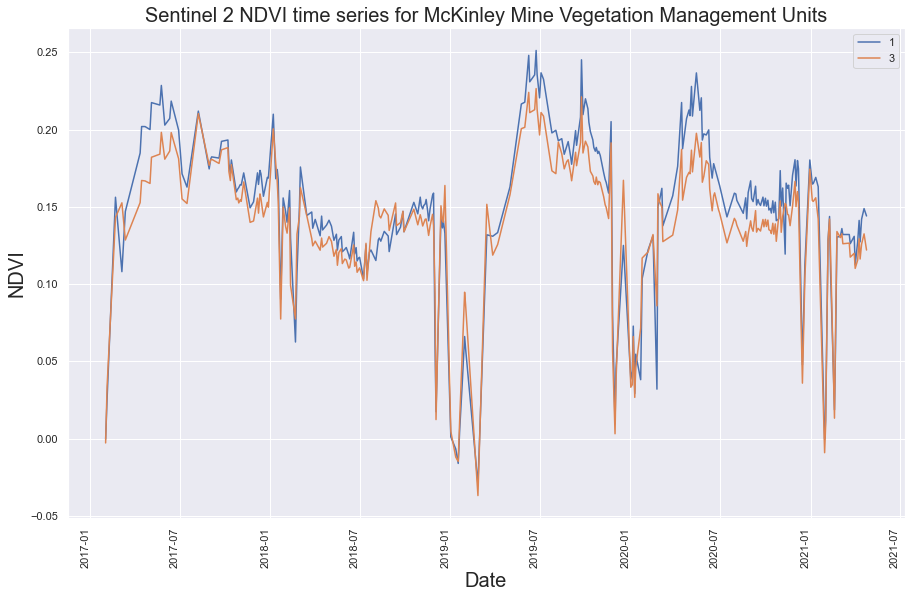

In [25]:
# Setup plot
fig, ax = plt.subplots(figsize=(15, 10))

# Build list of unique sites for legend
sites = fis_df_all.VMU.unique()

fis_df_all.reset_index().groupby('VMU').plot(x='date', y='mean', ax=ax)

# Legend and labels
plt.legend(sites)

plt.xlabel("Date", fontsize=20)
plt.ylabel("NDVI", fontsize=20)

ax.set_title(
    "Sentinel 2 NDVI time series for McKinley Mine Vegetation Management Units", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

### Export the results

In [ ]:
output_path = r"E:\McKinley\sentinelhub_output.csv"
fis_df_all.to_csv(output_path, index=True, header=True)

### Plot results

In [ ]:
# Remove 999
output_vmu_all_dates = output_vmu_all_dates[output_vmu_all_dates.VMU != 999]

# Setup plot
fig, ax = plt.subplots(figsize=(15, 15))

# Build list of unique sites for legend
sites = output_vmu_all_dates.VMU.unique()

# Convert the gdf to pd in order to plot properly
output_vmu_all_dates = pd.DataFrame(output_vmu_all_dates)

# Group the df by site for plotting purposes
output_vmu_all_dates.reset_index().groupby('VMU').plot(x='date', y='bandmath_mean', ax=ax)

# Legend and labels
plt.legend(sites)
ax.set(title="Band math results for McKinley VMU's",
       xlabel="Date",
       ylabel=bandmath_name)

plt.show()

In [ ]:
# Group the df by site for plotting purposes
#fis_df_all.reset_index().groupby('VMU').plot(x='date', y='mean', ax=ax)
# for name, group in fis_df_all.groupby('VMU'):
#     print(group['date'], group['mean'], group['VMU'])
#     plt.plot(group['date'], group['mean'], label=name)
    

# for site in sites:
#     test = fis_df_all[fis_df_all['VMU'] == site].reset_index(drop=True)
#     #print(test)
#     plt.plot(fis_df_all['date'], fis_df_all['mean'], label=site)



# f, ax1 = plt.subplots(figsize=(12, 6))
# vmu_poly.plot(ax=ax1)
# plt.show()

# [[]] will return a geodataframe not a pandas series
#vmu_poly = vmu_polys_exploded.loc[[index]]

# Convert geometry to WKT
#wkt = gpd.array.to_wkt(row)